In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 3.7 MB/s 
     |████████████████████████████████| 6.3 MB 54.9 MB/s 
     |████████████████████████████████| 15.4 MB 41.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
from shapely.geometry import Polygon
import json
import requests
from folium import plugins
from folium.plugins import MarkerCluster
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import font_manager, rcParams
!apt-get install fonts-nanum*
rcParams['font.family'] = 'NanumGothicCoding'
rcParams['axes.unicode_minus'] = False
font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20170925-1).
fonts-nanum-coding is already the newest version (2.5-1).
fonts-nanum-eco is already the newest version (1.000-6).
fonts-nanum-extra is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
# 서울 어린이 보호 구역 CPZ (Children Protection Zone)
CPZ = pd.read_csv('/content/drive/MyDrive/[D9&10] 데이터시각화 프로젝트_2조/Data/서울시 어린이보호구역 CARI.csv', index_col = 0)

# 서울 어린이 보호 구역 카메라CPZC (Children Protection Zone Camera)
CPZC = pd.read_csv('/content/drive/MyDrive/[D9&10] 데이터시각화 프로젝트_2조/Data/서울시 어린이보호구역 카메라.csv', index_col = 0)

# 서울 어린이 인구수 NSC (Number Of Seoul Children)
NSC = pd.read_csv('/content/drive/MyDrive/[D9&10] 데이터시각화 프로젝트_2조/Data/서울시 어린이 인구 현황.csv', index_col = 0)

# 서울 어린이 사고다발지역 WCA (Walking Child Accident)
WCA = pd.read_csv('/content/drive/MyDrive/[D9&10] 데이터시각화 프로젝트_2조/Data/어린이 사고다발지역.csv', index_col = 0)

# 서울 스쿨존 내 어린이 사고다발지역 (SchoolZoon Child Accident)
SCA = pd.read_csv('/content/drive/MyDrive/[D9&10] 데이터시각화 프로젝트_2조/Data/스쿨존내어린이 사고다발지역정보.csv', index_col = 0)

data = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
content = data.content
seoul_data = json.loads(content)

In [ ]:
data = pd.pivot_table(
    CPZ,
    values='대상시설명',
    index='행정구역',
    columns='시설종류',
    aggfunc=pd.Series.nunique,
    fill_value=0
)
data['어린이보호구역'] = data.sum(axis=1)
# data = data[['어린이보호구역', '초등학교', '유치원', '어린이집', '학원', '특수학교']]
data = pd.DataFrame(data['어린이보호구역'])

In [ ]:
data2 = pd.pivot_table(
    WCA,
    values = ['발생건수', '사상자수', '사망자수', '중상자수', '경상자수', '부상신고자수'],
    index='행정구역',
    aggfunc=sum,
    fill_value=0
)
# data2 = data2[['발생건수', '사상자수', '경상자수', '중상자수', '부상신고자수', '사망자수']]
data2 = pd.DataFrame(data2['발생건수'])

In [ ]:
data3 = pd.pivot_table(
    SCA,
    values = ['발생건수', '사상자수', '사망자수', '중상자수', '경상자수', '부상신고자수'],
    index='행정구역',
    aggfunc=sum,
    fill_value=0
)
data3 = data3.rename(columns={'발생건수': '발생건수(스쿨존)',
                              '사상자수': '사상자수(스쿨존)',
                              '사망자수': '사망자수(스쿨존)',
                              '중상자수': '중상자수(스쿨존)',
                              '경상자수': '경상자수(스쿨존)',
                              '부상신고자수': '부상신고자수(스쿨존)'})
# data3 = data3[['발생건수(스쿨존)', '사상자수(스쿨존)', '경상자수(스쿨존)', '중상자수(스쿨존)', '부상신고자수(스쿨존)', '사망자수(스쿨존)']]
data3 = pd.DataFrame(data3['발생건수(스쿨존)'])

In [ ]:
data4 = NSC.set_index('행정구역')
data4 = data4.drop('서울특별시')
data4 = data4.rename(columns={'2021년 어린이 인구수': '어린이인구수'})
data4 = pd.DataFrame(data4['어린이인구수'])
data4.replace(',', '', regex=True, inplace=True)
data4 = data4.apply(pd.to_numeric)

In [ ]:
merge_data = data.join([data2, data3, data4], how='outer')
merge_data.fillna(0, inplace=True)
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 강남구 to 중랑구
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   어린이보호구역    25 non-null     int64  
 1   발생건수       25 non-null     float64
 2   발생건수(스쿨존)  25 non-null     float64
 3   어린이인구수     25 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 1000.0+ bytes


In [ ]:
merge_data.head(1)

,어린이보호구역,발생건수,발생건수(스쿨존),어린이인구수
강남구,97,16.0,6.0,51721


In [ ]:
CPZC

,시설종류,대상시설명,행정구역,경도,위도,CARI,단속카메라대수
0,초등학교,화랑초교,노원구,127.093803,37.626918,0.00,5
1,초등학교,공릉초교,노원구,127.074631,37.618615,0.36,3
2,초등학교,중원초교,노원구,127.062768,37.643983,1.23,0
3,초등학교,원광초교,노원구,127.074916,37.654312,0.89,1
4,학원,국풍2000학원,노원구,127.076703,37.650631,0.89,1
...,...,...,...,...,...,...,...
1664,초등학교,서교초교,마포구,126.924378,37.554889,0.00,40
1665,초등학교,성산초교,마포구,126.910949,37.553410,0.00,23
1666,초등학교,신북초교,마포구,126.905363,37.571104,0.57,20
1667,초등학교,한서초교,마포구,126.949779,37.553648,0.00,29


In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot()


x = np.arange(len(merge_data))

ax1.bar(x-4, merge_data['어린이보호구역'], width=2, color='#FFFF00')
ax2 = ax1.twinx()
ax2.bar(x-2, merge_data['발생건수'], width=2, color='#00FFFF')
ax3 = ax1.twinx()
ax3.bar(x+0, merge_data['발생건수(스쿨존)'], width=2, color='#FF00FF')
ax4 = ax1.twinx()
ax4.bar(x+2, merge_data['어린이인구수'], width=2, color='#2EFEF7')

ax1.set_zorder(ax4.get_zorder)

plt.show()

NameError: ignored

In [ ]:
corr_feature.loc['어린이보호구역', '어린이보호구역']

1.0

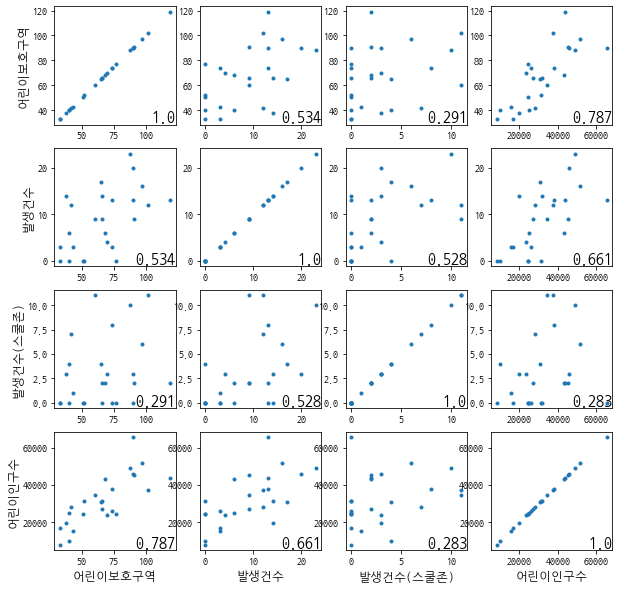

In [ ]:
feature = ['어린이보호구역','발생건수','발생건수(스쿨존)','어린이인구수']

corr_feature = merge_data[feature].corr()

fig = plt.figure(figsize=(10,10))

n_feature = len(feature)
for i in range(n_feature):
    for j in range(n_feature):
        ax = fig.add_subplot(n_feature,n_feature,i*n_feature + j + 1)
        plt.scatter(feature[j], feature[i], data=merge_data, s=9)
        
        if i == n_feature-1:
            plt.xlabel(feature[j], fontsize=12)
        if j == 0:
            plt.ylabel(feature[i], fontsize=12)
        ax.annotate(np.round(corr_feature.loc[feature[i],feature[j]], 3), xy=(1, 0), 
                    xycoords='axes fraction', fontsize=16,
                    horizontalalignment='right', verticalalignment='bottom')

plt.show()
# plt.savefig('행정구역별 상관관계.png')

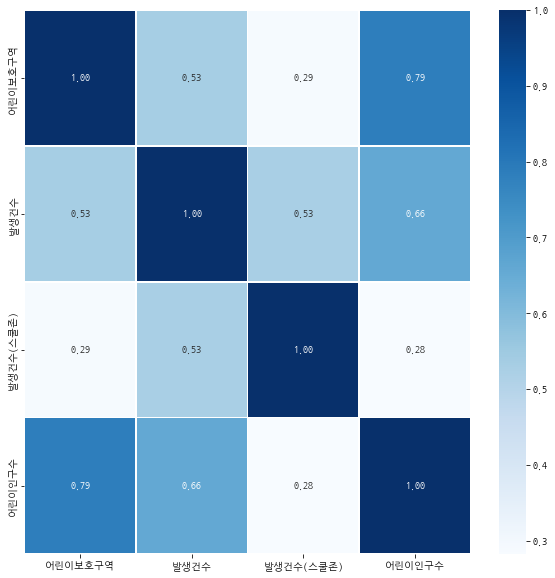

In [ ]:
corr_feature = merge_data[feature].corr()

fig = plt.figure(figsize=(10,10))

sns.heatmap(data=corr_feature, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [ ]:
CPZ = CPZ.drop(11, axis=0)

In [ ]:
CPZ['보호구역도로폭'].describe()

KeyError: ignored

## 어린이 보호구역에서 CARI와 보호구역도로폭 상관관계 알아보기

In [ ]:
feature = ['보호구역도로폭','CARI']

corr_feature = CPZ[feature].corr()

fig = plt.figure(figsize=(10,10))

n_feature = len(feature)
for i in range(n_feature):
    for j in range(n_feature):
        ax = fig.add_subplot(n_feature,n_feature,i*n_feature + j + 1)
        plt.scatter(feature[j], feature[i], data=CPZ, s=9)
        
        if i == n_feature-1:
            plt.xlabel(feature[j], fontsize=12)
        if j == 0:
            plt.ylabel(feature[i], fontsize=12)
        ax.annotate(np.round(corr_feature.loc[feature[i],feature[j]], 3), xy=(1, 0), 
                    xycoords='axes fraction', fontsize=16,
                    horizontalalignment='right', verticalalignment='bottom')
# plt.show()
plt.title('보호구역도로폭과 CARI 상관관계')
plt.savefig('보호구역도로폭과 CARI 상관관계.png')

In [ ]:
corr_feature = CPZ[feature].corr()

fig = plt.figure(figsize=(10,10))

sns.heatmap(data=corr_feature, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

plt.title('보호구역도로폭과 CARI 상관관계(heatmap)')
plt.show()
plt.savefig('보호구역도로폭과 CARI 상관관계(heatmap).png')

In [ ]:
CPZC

In [ ]:
feature = ['단속카메라대수','CARI']

corr_feature = CPZC[feature].corr()

fig = plt.figure(figsize=(10,10))
plt.title('absadf',
          )

n_feature = len(feature)
for i in range(n_feature):
    for j in range(n_feature):
        ax = fig.add_subplot(n_feature,n_feature,i*n_feature + j + 1)
        plt.scatter(feature[j], feature[i], data=CPZC, s=9)
        
        if i == n_feature-1:
            plt.xlabel(feature[j], fontsize=12)
        if j == 0:
            plt.ylabel(feature[i], fontsize=12)
        ax.annotate(np.round(corr_feature.loc[feature[i],feature[j]], 3), xy=(1, 0), 
                    xycoords='axes fraction', fontsize=16,
                    horizontalalignment='right', verticalalignment='bottom')


plt.show()
# plt.savefig('단속 카메라 대수와 CARI 상관관계.png')


In [ ]:
corr_feature = CPZC[feature].corr()

fig = plt.figure(figsize=(10,10))

sns.heatmap(data=corr_feature, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

plt.title('단속 카메라 대수와 CARI 상관관계')
plt.show()
plt.savefig('단속 카메라 대수와 CARI 상관관계.png')